In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tr1gg3rtrash/yoga-posture-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/yoga-posture-dataset


In [2]:
import os
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
# Set dataset path
dataset_path = "/kaggle/input/yoga-posture-dataset"

# List pose folders
poses = os.listdir(dataset_path)
print(f"Total poses: {len(poses)}")

Total poses: 48


In [9]:
# Filter out non-directory items
poses = [pose for pose in poses if os.path.isdir(os.path.join(dataset_path, pose))]
print(f"Total valid pose folders: {len(poses)}")

Total valid pose folders: 47


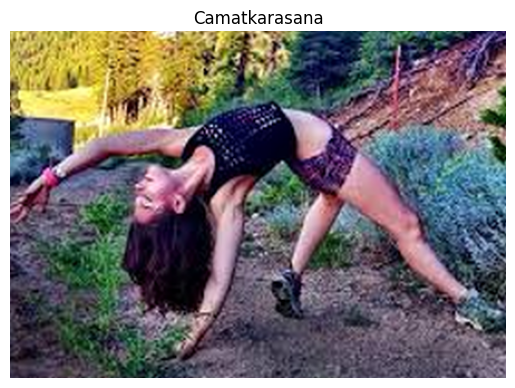

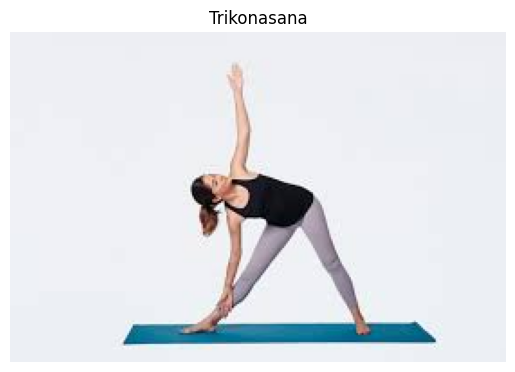

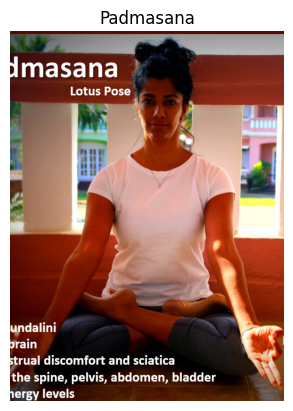

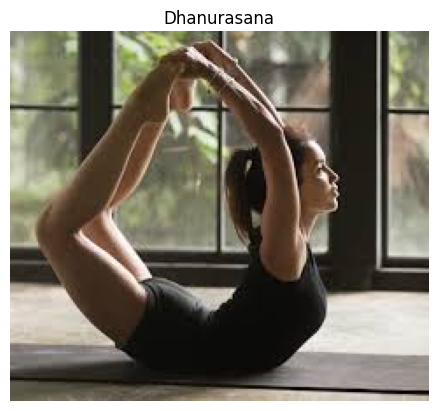

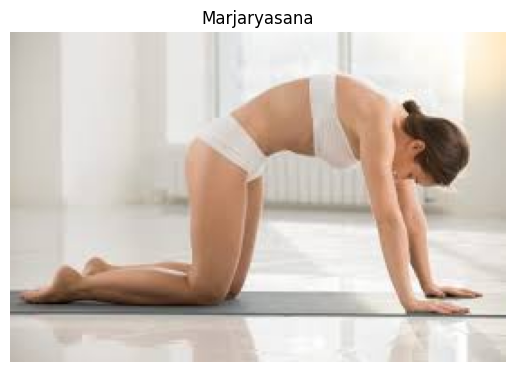

In [10]:
# Visualize sample images
for pose in poses[:5]:
    pose_path = os.path.join(dataset_path, pose)
    sample_image = os.listdir(pose_path)[0]
    image_path = os.path.join(pose_path, sample_image)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(pose)
    plt.axis("off")
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
import shutil

In [16]:
# Paths for train and test datasets
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

In [17]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [19]:
print("Source Path:", os.path.join(pose_path, img))
print("Destination Path:", os.path.join(train_dir, pose, img))


Source Path: /kaggle/input/yoga-posture-dataset/Adho Mukha Vrksasana/File42.png
Destination Path: /kaggle/working/train/Adho Mukha Vrksasana/File42.png


In [20]:
# Process each pose folder
for pose in poses:
    pose_path = os.path.join(dataset_path, pose)
    images = os.listdir(pose_path)
    
    # Split images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Ensure subdirectories exist for each pose
    os.makedirs(os.path.join(train_dir, pose), exist_ok=True)
    os.makedirs(os.path.join(test_dir, pose), exist_ok=True)
    
    # Copy files to train and test folders
    for img in train_images:
        shutil.copy(os.path.join(pose_path, img), os.path.join(train_dir, pose, img))
    for img in test_images:
        shutil.copy(os.path.join(pose_path, img), os.path.join(test_dir, pose, img))

In [21]:
print("Source Path:", os.path.join(pose_path, img))
print("Destination Path:", os.path.join(train_dir, pose, img))


Source Path: /kaggle/input/yoga-posture-dataset/Virabhadrasana One/File50.jpg
Destination Path: /kaggle/working/train/Virabhadrasana One/File50.jpg


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [29]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [25]:
# Load EfficientNetB0 pre-trained on ImageNet
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Add custom layers for yoga pose classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
output = Dense(len(poses), activation='softmax')(x)  # Final layer with softmax for classification


In [27]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [31]:
# Simple rescaling for validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [37]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 2185 images belonging to 47 classes.


In [38]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 571 images belonging to 47 classes.


In [39]:
for x, y in train_generator:
    print(f"Batch shape: {x.shape}, {y.shape}")
    break


Batch shape: (32, 224, 224, 3), (32, 47)


# Train the Model

In [36]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)


NameError: name 'steps_per_epoch' is not defined

In [35]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {test_generator.samples}")


Training samples: 2185
Validation samples: 571


In [40]:
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

NameError: name 'steps_per_epoch' is not defined

# Fine-Tune the Model

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [ ]:
# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

In [ ]:
model.save("efficientnet_yoga_pose_model.h5")


# retrial


In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image


In [42]:
# Paths for dataset
dataset_path = "/kaggle/input/yoga-posture-dataset"
train_dir = "train_data"
test_dir = "test_data"

In [43]:
# Parameters
IMG_SIZE = (224, 224)  # EfficientNet input size
BATCH_SIZE = 32


# 1. Data Preparation

In [44]:
# Create directories for train and test splits
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [45]:
# Function to handle transparency in images
def convert_to_rgb(image_path):
    with Image.open(image_path) as img:
        if img.mode in ("RGBA", "P"):
            img = img.convert("RGB")
        return img


In [46]:
# Split images into train and test folders
from sklearn.model_selection import train_test_split
import shutil

In [47]:
poses = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
for pose in poses:
    pose_path = os.path.join(dataset_path, pose)
    images = os.listdir(pose_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, pose), exist_ok=True)
    os.makedirs(os.path.join(test_dir, pose), exist_ok=True)

    for img in train_images:
        img_path = os.path.join(pose_path, img)
        shutil.copy(img_path, os.path.join(train_dir, pose, img))
    for img in test_images:
        img_path = os.path.join(pose_path, img)
        shutil.copy(img_path, os.path.join(test_dir, pose, img))


# 2. Data Augmentation and Generators

In [48]:
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [49]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)

Found 2185 images belonging to 47 classes.
Found 571 images belonging to 47 classes.


In [51]:
# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(poses), activation="softmax")
])

# 3. Model Creation

In [50]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [52]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 4. Callbacks

In [54]:
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


# 5. Training the Model

In [55]:
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

In [56]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/68 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0236 - loss: 3.8407

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.0243 - loss: 3.8333 - val_accuracy: 0.0257 - val_loss: 3.7805
Epoch 2/10
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.0000e+00 - loss: 3.8372

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 3.8372 - val_accuracy: 0.0000e+00 - val_loss: 3.8037
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.0297 - loss: 3.7710 - val_accuracy: 0.0368 - val_loss: 3.7649
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0625 - loss: 3.7689 - val_accuracy: 0.0000e+00 - val_loss: 3.8076
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.0332 - loss: 3.7610 - val_accuracy: 0.0368 - val_loss: 3.7653
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0625 - loss: 3.7851 - val_accuracy: 0.0000e+00 - val_loss: 3.6962
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.0328 - loss: 3.7675 - val_accuracy: 0.0368 - val_loss: 3.7594
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0000e+00 - loss: 3.8180 - val_accuracy: 0.0000e+00 - val_loss: 3.7977
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.0336 - loss: 3.7715 - val_accurac

# 6. Visualize Training Results

In [57]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

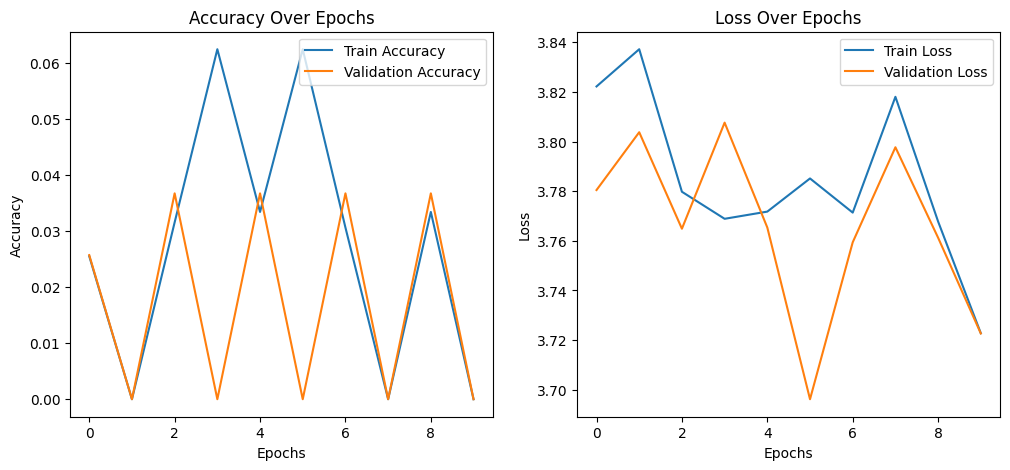

In [58]:
plot_training_history(history)

# 7. Evaluation

In [59]:
# Generate predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


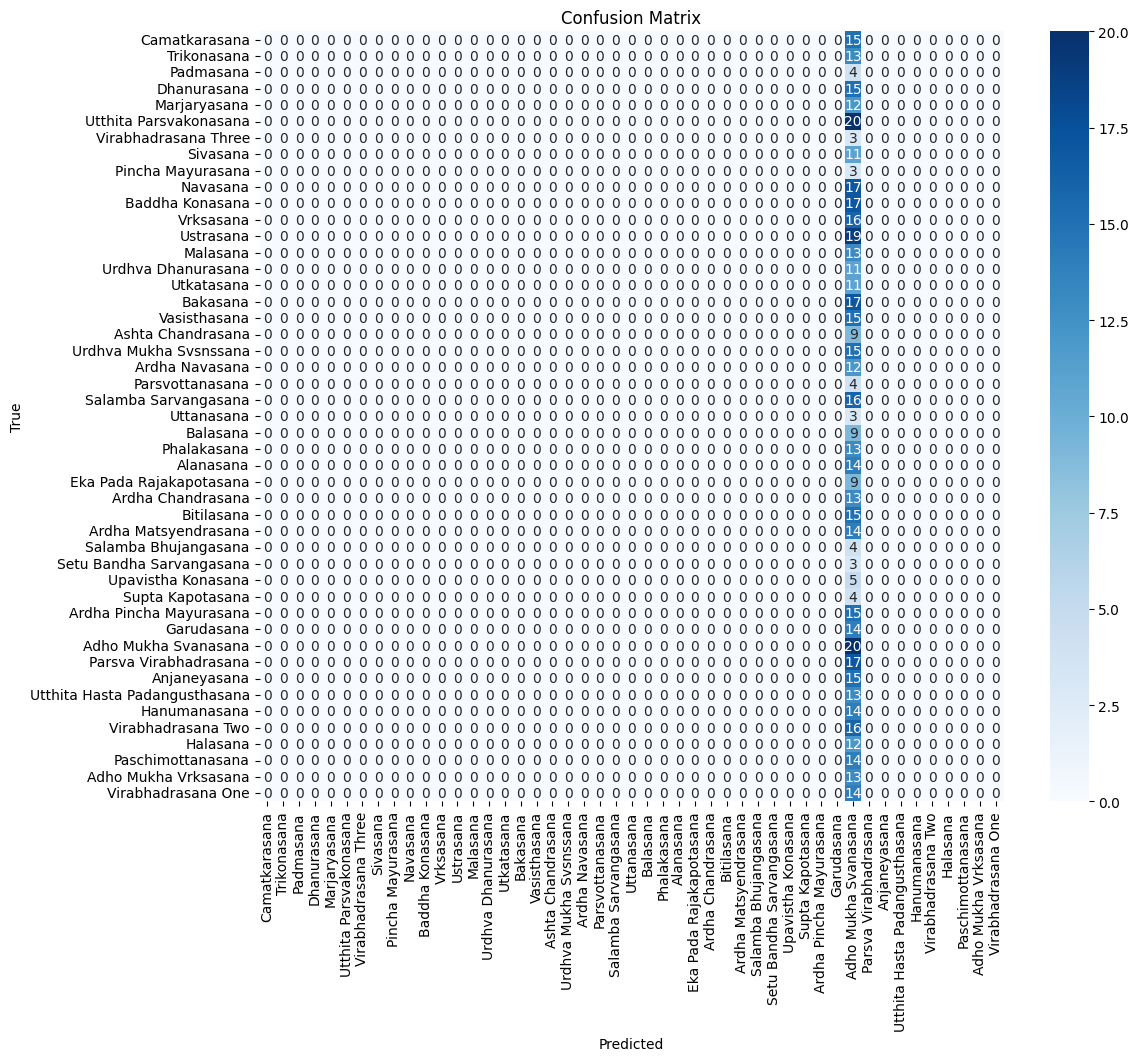

In [60]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=poses, yticklabels=poses)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [61]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=poses))

                               precision    recall  f1-score   support

                Camatkarasana       0.00      0.00      0.00        15
                  Trikonasana       0.00      0.00      0.00        13
                    Padmasana       0.00      0.00      0.00         4
                  Dhanurasana       0.00      0.00      0.00        15
                 Marjaryasana       0.00      0.00      0.00        12
       Utthita Parsvakonasana       0.00      0.00      0.00        20
         Virabhadrasana Three       0.00      0.00      0.00         3
                     Sivasana       0.00      0.00      0.00        11
            Pincha Mayurasana       0.00      0.00      0.00         3
                     Navasana       0.00      0.00      0.00        17
              Baddha Konasana       0.00      0.00      0.00        17
                    Vrksasana       0.00      0.00      0.00        16
                    Ustrasana       0.00      0.00      0.00        19
     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# third trial


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from PIL import Image, ImageChops, ImageEnhance

In [3]:
# Helper functions (for visualization and ELA)
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    compressed_img = cv2.imread(temp_filename)
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [5]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
    p = np.random.choice(items)
    return p.as_posix()

In [6]:
# Set batch size and image size
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [7]:
# Load dataset
dataset = "../input/yoga-posture-dataset"
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [8]:
# Create DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

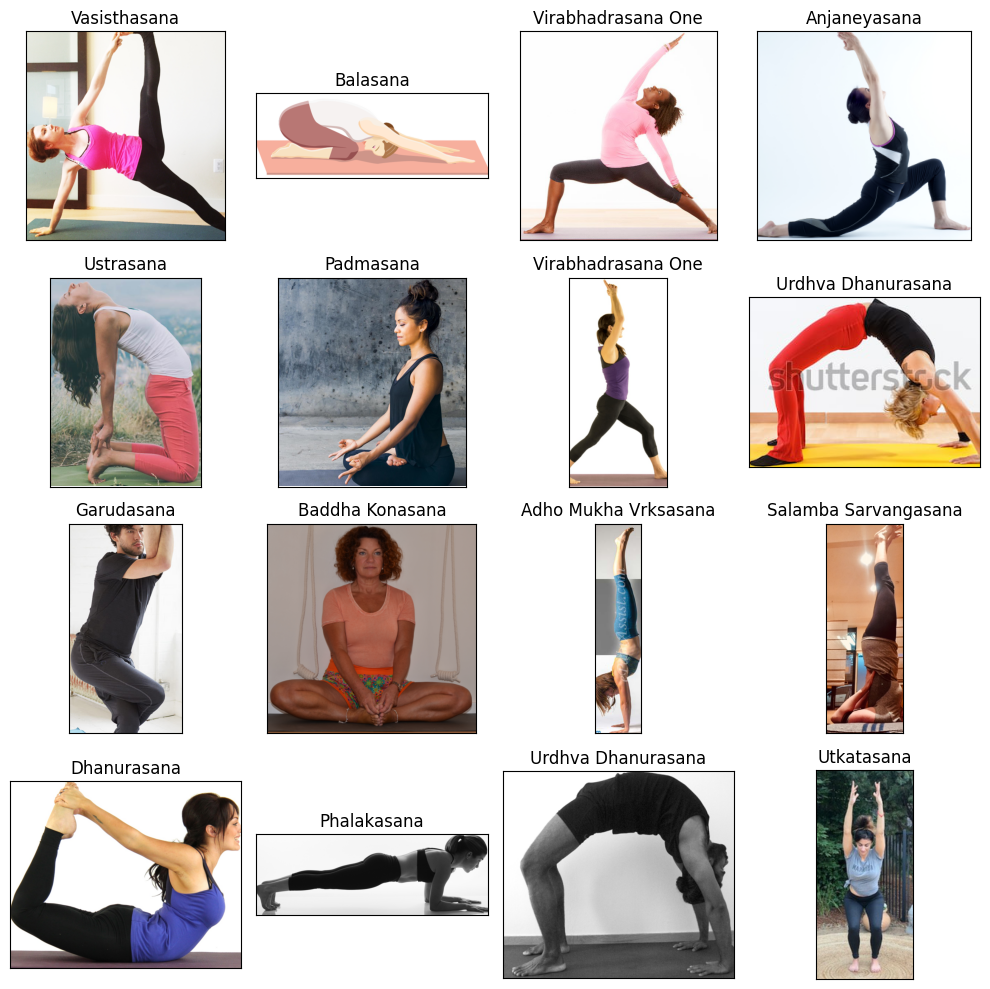

In [9]:
# Display a random sample of images
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
# Split into train and test sets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)


In [11]:
# Data generators
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)


In [12]:
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)


In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1508 validated image filenames belonging to 43 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 376 validated image filenames belonging to 43 classes.


In [15]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 471 validated image filenames belonging to 40 classes.


In [16]:
# Load EfficientNetB0 model
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
base_model.trainable = False

In [18]:
# Define model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(train_images.class_indices), activation='softmax')(x)
model = Model(inputs, outputs)

In [19]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
tensorboard = TensorBoard(log_dir="logs")

In [23]:
def preprocess_image(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image


In [24]:
# Check the number of samples
print(f"Training samples: {train_images.samples}")
print(f"Validation samples: {val_images.samples}")


Training samples: 1508
Validation samples: 376


In [34]:
# Ensure correct steps per epoch
steps_per_epoch = train_images.samples // train_images.batch_size
validation_steps = val_images.samples // val_images.batch_size

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, tensorboard],
    verbose=1  # Display training progress
)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8065 - loss: 0.9609 - val_accuracy: 0.6903 - val_loss: 1.3534
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.7812 - loss: 0.9069 - val_accuracy: 0.5833 - val_loss: 1.7733
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8345 - loss: 0.9118 - val_accuracy: 0.7045 - val_loss: 1.3471
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8125 - loss: 0.6945 - val_accuracy: 0.5833 - val_loss: 1.2409
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8324 - loss: 0.8604 - val_accuracy: 0.6960 - val_loss: 1.2849


In [35]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066,534 (19.33 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 677,976 (2.59 MB)

In [36]:
print("Class indices:", train_images.class_indices)
print("Number of classes:", len(train_images.class_indices))


Class indices: {'Adho Mukha Svanasana': 0, 'Adho Mukha Vrksasana': 1, 'Alanasana': 2, 'Anjaneyasana': 3, 'Ardha Chandrasana': 4, 'Ardha Matsyendrasana': 5, 'Ardha Navasana': 6, 'Ardha Pincha Mayurasana': 7, 'Ashta Chandrasana': 8, 'Baddha Konasana': 9, 'Bakasana': 10, 'Balasana': 11, 'Bitilasana': 12, 'Camatkarasana': 13, 'Dhanurasana': 14, 'Eka Pada Rajakapotasana': 15, 'Garudasana': 16, 'Halasana': 17, 'Hanumanasana': 18, 'Malasana': 19, 'Marjaryasana': 20, 'Padmasana': 21, 'Parsvottanasana': 22, 'Paschimottanasana': 23, 'Phalakasana': 24, 'Pincha Mayurasana': 25, 'Salamba Bhujangasana': 26, 'Salamba Sarvangasana': 27, 'Setu Bandha Sarvangasana': 28, 'Sivasana': 29, 'Supta Kapotasana': 30, 'Urdhva Dhanurasana': 31, 'Urdhva Mukha Svsnssana': 32, 'Ustrasana': 33, 'Utkatasana': 34, 'Uttanasana': 35, 'Utthita Hasta Padangusthasana': 36, 'Utthita Parsvakonasana': 37, 'Vasisthasana': 38, 'Virabhadrasana One': 39, 'Virabhadrasana Three': 40, 'Virabhadrasana Two': 41, 'Vrksasana': 42}
Number

In [33]:
# Evaluate on test data
results = model.evaluate(test_images, verbose=1)

# Display the results
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_24/3874418538.py", line 2, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 425, in evaluate

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 161, in one_step_on_iterator

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 150, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 81, in test_step

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1576, in categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1482, in categorical_crossentropy

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 564, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,43] labels_size=[32,40]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_one_step_on_iterator_57512]

In [37]:
# Generate predictions
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_images.classes


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


In [38]:
from sklearn.metrics import classification_report

# Classification report
class_names = list(test_images.class_indices.keys())  # Retrieve class names
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)


ValueError: Number of classes, 43, does not match size of target_names, 40. Try specifying the labels parameter

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [ ]:

# Call the function to plot
plot_history(history)

In [ ]:
# Get misclassified indices
misclassified_indices = np.where(predicted_classes != true_classes)[0]

In [ ]:
# Display a few misclassified examples
import random
random_indices = random.sample(list(misclassified_indices), 9)
plt.figure(figsize=(10, 10))


In [ ]:
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(test_images.filepaths[idx])
    plt.imshow(img)
    plt.title(f"True: {class_names[true_classes[idx]]}, Pred: {class_names[predicted_classes[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
print(f"Training samples: {train_images.samples}")
print(f"Validation samples: {val_images.samples}")


# another trial

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from PIL import Image, ImageChops, ImageEnhance

In [3]:
# === Helper Functions ===
def preprocess_image(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

In [4]:
# === Dataset Preparation ===
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [5]:
dataset = "../input/yoga-posture-dataset"  # Replace with your dataset path
image_dir = Path(dataset)

In [6]:
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [7]:
# Create DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [8]:
# Split into train and test sets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)


In [9]:
# Data Generators
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

In [10]:
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1508 validated image filenames belonging to 43 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 376 validated image filenames belonging to 43 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 471 validated image filenames belonging to 40 classes.


In [14]:
# === Model and Optimizer Comparison ===
models_to_test = {
    "EfficientNetB0": EfficientNetB0,
    "ResNet50": ResNet50,
}

In [15]:
optimizers_to_test = {
    "Adam": Adam(learning_rate=1e-4),
    "SGD": SGD(learning_rate=1e-3),
    "RMSprop": RMSprop(learning_rate=1e-4),
}

In [16]:
results = {}

In [ ]:
# Manually encode missing classes in the test set
from tensorflow.keras.utils import to_categorical

# Check if any class in test set is missing
missing_classes = set(range(43)) - set(test_images.class_indices.values())
print(f"Missing classes in test set: {missing_classes}")

# Ensure labels are encoded to fit the model's expected 43 output classes
for x_batch, y_batch in test_images:
    y_batch_one_hot = to_categorical(y_batch, num_classes=43)
    break  # Stop after checking the first batch

# Continue with evaluation
test_loss, test_accuracy = model.evaluate(test_images, verbose=0)


In [ ]:
for model_name, base_model_fn in models_to_test.items():
    for optimizer_name, optimizer in optimizers_to_test.items():
        print(f"Training {model_name} with {optimizer_name}...")
        
        # Define the base model
        base_model = base_model_fn(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
        base_model.trainable = False  # Freeze base layers
        
        # Build the model
        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = base_model(inputs)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(len(train_images.class_indices), activation='softmax')(x)
        model = Model(inputs, outputs)
        
        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        checkpoint = ModelCheckpoint(f"{model_name}_{optimizer_name}_best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
        early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        tensorboard = TensorBoard(log_dir=f"logs/{model_name}_{optimizer_name}")
        
        # Train the model
        history = model.fit(
            train_images,
            validation_data=val_images,
            epochs=5,  # Adjust as needed
            steps_per_epoch=train_images.samples // train_images.batch_size,
            validation_steps=val_images.samples // val_images.batch_size,
            callbacks=[checkpoint, early_stopping, tensorboard],
            verbose=1
        )
        
        # Evaluate on test data
        test_loss, test_accuracy = model.evaluate(test_images, verbose=0)
        results[(model_name, optimizer_name)] = {"accuracy": test_accuracy, "loss": test_loss}


In [18]:
print(f"Class indices: {train_images.class_indices}")
print(f"Number of classes: {len(train_images.class_indices)}")


Class indices: {'Adho Mukha Svanasana': 0, 'Adho Mukha Vrksasana': 1, 'Alanasana': 2, 'Anjaneyasana': 3, 'Ardha Chandrasana': 4, 'Ardha Matsyendrasana': 5, 'Ardha Navasana': 6, 'Ardha Pincha Mayurasana': 7, 'Ashta Chandrasana': 8, 'Baddha Konasana': 9, 'Bakasana': 10, 'Balasana': 11, 'Bitilasana': 12, 'Camatkarasana': 13, 'Dhanurasana': 14, 'Eka Pada Rajakapotasana': 15, 'Garudasana': 16, 'Halasana': 17, 'Hanumanasana': 18, 'Malasana': 19, 'Marjaryasana': 20, 'Padmasana': 21, 'Parsvottanasana': 22, 'Paschimottanasana': 23, 'Phalakasana': 24, 'Pincha Mayurasana': 25, 'Salamba Bhujangasana': 26, 'Salamba Sarvangasana': 27, 'Setu Bandha Sarvangasana': 28, 'Sivasana': 29, 'Supta Kapotasana': 30, 'Urdhva Dhanurasana': 31, 'Urdhva Mukha Svsnssana': 32, 'Ustrasana': 33, 'Utkatasana': 34, 'Uttanasana': 35, 'Utthita Hasta Padangusthasana': 36, 'Utthita Parsvakonasana': 37, 'Vasisthasana': 38, 'Virabhadrasana One': 39, 'Virabhadrasana Three': 40, 'Virabhadrasana Two': 41, 'Vrksasana': 42}
Number

In [19]:
print(f"Model output shape: {model.output_shape}")


Model output shape: (None, 43)


In [20]:
# Check batch shapes from test generator
for x_batch, y_batch in test_images:
    print(f"Input shape: {x_batch.shape}, Label shape: {y_batch.shape}")
    break

Input shape: (32, 224, 224, 3), Label shape: (32, 40)


In [21]:
print(f"Training set unique labels: {len(train_images.class_indices)}")



Training set unique labels: 43


In [22]:

print(f"Test set unique labels: {len(test_images.class_indices)}")


Test set unique labels: 40


In [ ]:
# === Results Visualization ===
result_df = pd.DataFrame(results).T.reset_index()
result_df.columns = ["Model", "Optimizer", "Accuracy", "Loss"]

In [ ]:
# Plot Accuracy
plt.figure(figsize=(15, 6))
result_df.sort_values("Accuracy", ascending=False).plot(
    kind="bar", x="Model", y="Accuracy", color="skyblue", legend=False
)
plt.title("Model and Optimizer Accuracy Comparison")
plt.xlabel("Model + Optimizer")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
# Plot Loss
plt.figure(figsize=(15, 6))
result_df.sort_values("Loss").plot(
    kind="bar", x="Model", y="Loss", color="salmon", legend=False
)
plt.title("Model and Optimizer Loss Comparison")
plt.xlabel("Model + Optimizer")
plt.ylabel("Loss")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
# Display sorted results
print("Model Comparison Results:")
print(result_df.sort_values("Accuracy", ascending=False))